# 补充资料

In [1]:
# 准备工作
#准备工作
# 基本包的导入
import numpy as np
import os

# 画图相关
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

# 忽略警告
import warnings
warnings.filterwarnings(action='ignore', module='scipy', message='internal')

# 图片存储目录
PROJECT_ROOT_DIR = '../'
CHAPTER_ID = 'end_to_end_project'
IMAGE_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)

def save_fig(fig_id, tight_layout=True, fig_extension='png', resolution=300):
    path = os.path.join(IMAGE_PATH, fig_id + "." + fig_extension)
    print("保存图片:", fig_id)
    
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)


# 加载数据
HOUSING_PATH = os.path.join("../datasets", "housing")
def loading_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

housing = loading_housing_data()

housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True)

from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42) 
for train_index, test_index in split.split(housing, housing["income_cat"]):
        strat_train_set = housing.loc[train_index]
        strat_test_set = housing.loc[test_index]

for set in (strat_train_set, strat_test_set): 
    set.drop(["income_cat"], axis=1, inplace=True)
    
# 复制一份训练集，并drop预测结果后语后续评估。
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

from sklearn.base import BaseEstimator, TransformerMixin

# column index
rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]
        
# 上述函数，其输入是包含1个多个枚举类别的2D数组，需要reshape成为这种数组
# from sklearn.preprocessing import CategoricalEncoder  #后面会添加这个方法

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_array
from sklearn.preprocessing import LabelEncoder


from scipy import sparse

# 后面再去理解
class CategoricalEncoder(BaseEstimator, TransformerMixin):
    """Encode categorical features as a numeric array.
    The input to this transformer should be a matrix of integers or strings,
    denoting the values taken on by categorical (discrete) features.
    The features can be encoded using a one-hot aka one-of-K scheme
    (``encoding='onehot'``, the default) or converted to ordinal integers
    (``encoding='ordinal'``).
    This encoding is needed for feeding categorical data to many scikit-learn
    estimators, notably linear models and SVMs with the standard kernels.
    Read more in the :ref:`User Guide <preprocessing_categorical_features>`.
    Parameters
    ----------
    encoding : str, 'onehot', 'onehot-dense' or 'ordinal'
        The type of encoding to use (default is 'onehot'):
        - 'onehot': encode the features using a one-hot aka one-of-K scheme
          (or also called 'dummy' encoding). This creates a binary column for
          each category and returns a sparse matrix.
        - 'onehot-dense': the same as 'onehot' but returns a dense array
          instead of a sparse matrix.
        - 'ordinal': encode the features as ordinal integers. This results in
          a single column of integers (0 to n_categories - 1) per feature.
    categories : 'auto' or a list of lists/arrays of values.
        Categories (unique values) per feature:
        - 'auto' : Determine categories automatically from the training data.
        - list : ``categories[i]`` holds the categories expected in the ith
          column. The passed categories are sorted before encoding the data
          (used categories can be found in the ``categories_`` attribute).
    dtype : number type, default np.float64
        Desired dtype of output.
    handle_unknown : 'error' (default) or 'ignore'
        Whether to raise an error or ignore if a unknown categorical feature is
        present during transform (default is to raise). When this is parameter
        is set to 'ignore' and an unknown category is encountered during
        transform, the resulting one-hot encoded columns for this feature
        will be all zeros.
        Ignoring unknown categories is not supported for
        ``encoding='ordinal'``.
    Attributes
    ----------
    categories_ : list of arrays
        The categories of each feature determined during fitting. When
        categories were specified manually, this holds the sorted categories
        (in order corresponding with output of `transform`).
    Examples
    --------
    Given a dataset with three features and two samples, we let the encoder
    find the maximum value per feature and transform the data to a binary
    one-hot encoding.
    >>> from sklearn.preprocessing import CategoricalEncoder
    >>> enc = CategoricalEncoder(handle_unknown='ignore')
    >>> enc.fit([[0, 0, 3], [1, 1, 0], [0, 2, 1], [1, 0, 2]])
    ... # doctest: +ELLIPSIS
    CategoricalEncoder(categories='auto', dtype=<... 'numpy.float64'>,
              encoding='onehot', handle_unknown='ignore')
    >>> enc.transform([[0, 1, 1], [1, 0, 4]]).toarray()
    array([[ 1.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.],
           [ 0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.]])
    See also
    --------
    sklearn.preprocessing.OneHotEncoder : performs a one-hot encoding of
      integer ordinal features. The ``OneHotEncoder assumes`` that input
      features take on values in the range ``[0, max(feature)]`` instead of
      using the unique values.
    sklearn.feature_extraction.DictVectorizer : performs a one-hot encoding of
      dictionary items (also handles string-valued features).
    sklearn.feature_extraction.FeatureHasher : performs an approximate one-hot
      encoding of dictionary items or strings.
    """

    def __init__(self, encoding='onehot', categories='auto', dtype=np.float64,
                 handle_unknown='error'):
        self.encoding = encoding
        self.categories = categories
        self.dtype = dtype
        self.handle_unknown = handle_unknown

    def fit(self, X, y=None):
        """Fit the CategoricalEncoder to X.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_feature]
            The data to determine the categories of each feature.
        Returns
        -------
        self
        """

        if self.encoding not in ['onehot', 'onehot-dense', 'ordinal']:
            template = ("encoding should be either 'onehot', 'onehot-dense' "
                        "or 'ordinal', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.handle_unknown not in ['error', 'ignore']:
            template = ("handle_unknown should be either 'error' or "
                        "'ignore', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.encoding == 'ordinal' and self.handle_unknown == 'ignore':
            raise ValueError("handle_unknown='ignore' is not supported for"
                             " encoding='ordinal'")

        X = check_array(X, dtype=np.object, accept_sparse='csc', copy=True)
        n_samples, n_features = X.shape

        self._label_encoders_ = [LabelEncoder() for _ in range(n_features)]

        for i in range(n_features):
            le = self._label_encoders_[i]
            Xi = X[:, i]
            if self.categories == 'auto':
                le.fit(Xi)
            else:
                valid_mask = np.in1d(Xi, self.categories[i])
                if not np.all(valid_mask):
                    if self.handle_unknown == 'error':
                        diff = np.unique(Xi[~valid_mask])
                        msg = ("Found unknown categories {0} in column {1}"
                               " during fit".format(diff, i))
                        raise ValueError(msg)
                le.classes_ = np.array(np.sort(self.categories[i]))

        self.categories_ = [le.classes_ for le in self._label_encoders_]

        return self

    def transform(self, X):
        """Transform X using one-hot encoding.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_features]
            The data to encode.
        Returns
        -------
        X_out : sparse matrix or a 2-d array
            Transformed input.
        """
        X = check_array(X, accept_sparse='csc', dtype=np.object, copy=True)
        n_samples, n_features = X.shape
        X_int = np.zeros_like(X, dtype=np.int)
        X_mask = np.ones_like(X, dtype=np.bool)

        for i in range(n_features):
            valid_mask = np.in1d(X[:, i], self.categories_[i])

            if not np.all(valid_mask):
                if self.handle_unknown == 'error':
                    diff = np.unique(X[~valid_mask, i])
                    msg = ("Found unknown categories {0} in column {1}"
                           " during transform".format(diff, i))
                    raise ValueError(msg)
                else:
                    # Set the problematic rows to an acceptable value and
                    # continue `The rows are marked `X_mask` and will be
                    # removed later.
                    X_mask[:, i] = valid_mask
                    X[:, i][~valid_mask] = self.categories_[i][0]
            X_int[:, i] = self._label_encoders_[i].transform(X[:, i])

        if self.encoding == 'ordinal':
            return X_int.astype(self.dtype, copy=False)

        mask = X_mask.ravel()
        n_values = [cats.shape[0] for cats in self.categories_]
        n_values = np.array([0] + n_values)
        indices = np.cumsum(n_values)

        column_indices = (X_int + indices[:-1]).ravel()[mask]
        row_indices = np.repeat(np.arange(n_samples, dtype=np.int32),
                                n_features)[mask]
        data = np.ones(n_samples * n_features)[mask]

        out = sparse.csc_matrix((data, (row_indices, column_indices)),
                                shape=(n_samples, indices[-1]),
                                dtype=self.dtype).tocsr()
        if self.encoding == 'onehot-dense':
            return out.toarray()
        else:
            return out

# 另外一个转换器：选择一个子集
from sklearn.base import BaseEstimator, TransformerMixin

# 如上，对于数据集需要进行大量的转换，并且要有一定的顺序。因此sklearn提供了pipeline来进行处理。
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler


# Create a class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values
    
# 由于只能对数值类型进行处理，因此需要去除类别数据。
housing_num = housing.drop("ocean_proximity", axis=1)
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]
num_pipeline = Pipeline([
    ('selector', DataFrameSelector(num_attribs)),
    ('imputer', Imputer(strategy="median")),
    ('attr_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler())
])
cat_pipeline = Pipeline([
    ('selector', DataFrameSelector(cat_attribs)),
    ("cat_encoder", CategoricalEncoder(encoding='onehot-dense'))
])
from sklearn.pipeline import FeatureUnion
full_pipeline = FeatureUnion(transformer_list=[
    ("num_pipeline", num_pipeline),
    ("cat_pipeline", cat_pipeline),
])

/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [13]:
# 运用结合pipeline对数值类型，类别类型同时进行转换
housing_prepare = full_pipeline.fit_transform(housing)
housing_prepare.shape  # 由于数据大， 运行慢，减小数据

housing_prepare = housing_prepare[:3000]
housing_labels = housing_labels[:3000]

# 1. 使用不用内核的svm预测

In [14]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
param_grid = [
    {"kernel": ["linear"], "C":[10, 30, 100, 300, 1000, 3000, 10000, 30000]},
    {'kernel': ['rbf'], 'C': [1.0, 3.0, 10., 30., 100., 300., 1000.0],
    'gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0]},
]

svm_reg = SVR()
grid_search = GridSearchCV(svm_reg, param_grid, cv=5, scoring="neg_mean_squared_error", verbose=2, n_jobs=-1)
grid_search.fit(housing_prepare, housing_labels)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] C=10, kernel=linear .............................................
[CV] C=10, kernel=linear .............................................
[CV] C=10, kernel=linear .............................................
[CV] C=10, kernel=linear .............................................
[CV] C=10, kernel=linear .............................................
[CV] C=30, kernel=linear .............................................
[CV] C=30, kernel=linear .............................................
[CV] C=30, kernel=linear .............................................
[CV] .............................. C=10, kernel=linear, total=   0.4s
[CV] .............................. C=10, kernel=linear, total=   0.4s
[CV] C=30, kernel=linear .............................................
[CV] C=30, kernel=linear .............................................
[CV] .............................. C=10, kernel=linear, total=   0.4s
[CV] ..........

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.2s


[CV] ........................... C=10000, kernel=linear, total=   0.5s
[CV] C=30000, kernel=linear ..........................................
[CV] ........................... C=10000, kernel=linear, total=   0.5s
[CV] C=30000, kernel=linear ..........................................
[CV] ........................... C=10000, kernel=linear, total=   0.6s
[CV] C=1.0, gamma=0.01, kernel=rbf ...................................
[CV] ........................... C=10000, kernel=linear, total=   0.6s
[CV] C=1.0, gamma=0.01, kernel=rbf ...................................
[CV] ........................... C=10000, kernel=linear, total=   0.6s
[CV] C=1.0, gamma=0.01, kernel=rbf ...................................
[CV] ........................... C=30000, kernel=linear, total=   1.0s
[CV] C=1.0, gamma=0.01, kernel=rbf ...................................
[CV] ........................... C=30000, kernel=linear, total=   1.0s
[CV] C=1.0, gamma=0.01, kernel=rbf ...................................
[CV] .

[CV] ..................... C=3.0, gamma=0.3, kernel=rbf, total=   0.5s
[CV] C=3.0, gamma=3.0, kernel=rbf ....................................
[CV] ..................... C=3.0, gamma=0.3, kernel=rbf, total=   0.5s
[CV] C=3.0, gamma=3.0, kernel=rbf ....................................
[CV] ..................... C=3.0, gamma=1.0, kernel=rbf, total=   0.5s
[CV] C=3.0, gamma=3.0, kernel=rbf ....................................
[CV] ..................... C=3.0, gamma=1.0, kernel=rbf, total=   0.5s
[CV] C=3.0, gamma=3.0, kernel=rbf ....................................
[CV] ..................... C=3.0, gamma=1.0, kernel=rbf, total=   0.5s
[CV] C=10.0, gamma=0.01, kernel=rbf ..................................
[CV] ..................... C=3.0, gamma=1.0, kernel=rbf, total=   0.5s
[CV] C=10.0, gamma=0.01, kernel=rbf ..................................
[CV] ..................... C=3.0, gamma=1.0, kernel=rbf, total=   0.5s
[CV] C=10.0, gamma=0.01, kernel=rbf ..................................
[CV] .

[CV] .................... C=30.0, gamma=0.3, kernel=rbf, total=   0.5s
[CV] C=30.0, gamma=1.0, kernel=rbf ...................................


[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   14.1s


[CV] .................... C=30.0, gamma=0.3, kernel=rbf, total=   0.5s
[CV] C=30.0, gamma=3.0, kernel=rbf ...................................
[CV] .................... C=30.0, gamma=0.3, kernel=rbf, total=   0.5s
[CV] C=30.0, gamma=3.0, kernel=rbf ...................................
[CV] .................... C=30.0, gamma=0.3, kernel=rbf, total=   0.5s
[CV] C=30.0, gamma=3.0, kernel=rbf ...................................
[CV] .................... C=30.0, gamma=1.0, kernel=rbf, total=   0.5s
[CV] C=30.0, gamma=3.0, kernel=rbf ...................................
[CV] .................... C=30.0, gamma=1.0, kernel=rbf, total=   0.5s
[CV] C=30.0, gamma=3.0, kernel=rbf ...................................
[CV] .................... C=30.0, gamma=1.0, kernel=rbf, total=   0.5s
[CV] C=100.0, gamma=0.01, kernel=rbf .................................
[CV] .................... C=30.0, gamma=1.0, kernel=rbf, total=   0.5s
[CV] C=100.0, gamma=0.01, kernel=rbf .................................
[CV] .

[CV] ................... C=300.0, gamma=0.3, kernel=rbf, total=   0.5s
[CV] C=300.0, gamma=1.0, kernel=rbf ..................................
[CV] ................... C=300.0, gamma=0.3, kernel=rbf, total=   0.5s
[CV] C=300.0, gamma=1.0, kernel=rbf ..................................
[CV] ................... C=300.0, gamma=0.3, kernel=rbf, total=   0.5s
[CV] C=300.0, gamma=3.0, kernel=rbf ..................................
[CV] ................... C=300.0, gamma=0.3, kernel=rbf, total=   0.5s
[CV] C=300.0, gamma=3.0, kernel=rbf ..................................
[CV] ................... C=300.0, gamma=0.3, kernel=rbf, total=   0.5s
[CV] C=300.0, gamma=3.0, kernel=rbf ..................................
[CV] ................... C=300.0, gamma=1.0, kernel=rbf, total=   0.5s
[CV] C=300.0, gamma=3.0, kernel=rbf ..................................
[CV] ................... C=300.0, gamma=1.0, kernel=rbf, total=   0.5s
[CV] C=300.0, gamma=3.0, kernel=rbf ..................................
[CV] .

[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   24.2s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'kernel': ['linear'], 'C': [10, 30, 100, 300, 1000, 3000, 10000, 30000]}, {'kernel': ['rbf'], 'C': [1.0, 3.0, 10.0, 30.0, 100.0, 300.0, 1000.0], 'gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=2)

减少数据集后，使用网格搜索可以看到不同情况的运行数据。

In [17]:
negative_mse = grid_search.best_score_
rmse = np.sqrt(-negative_mse)
rmse  # 结果比随机森林要差很多

67310.91955011517

In [18]:
grid_search.best_params_

{'C': 30000, 'kernel': 'linear'}

# 2. 使用随机搜索代替网格搜索

In [23]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import expon, reciprocal

param_distribs = {
    'kernel':["linear", "rbf"],
    "C":reciprocal(20, 20000),
    "gamma":expon(scale=1.0),}
svm_reg = SVR()

rnd_search = RandomizedSearchCV(svm_reg, param_distributions=param_distribs,
                                n_iter=50, cv=5, scoring='neg_mean_squared_error',
                                verbose=2, n_jobs=4, random_state=42)
rnd_search.fit(housing_prepare, housing_labels)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] C=265.8583788632432, gamma=3.010121430917521, kernel=linear .....
[CV] C=265.8583788632432, gamma=3.010121430917521, kernel=linear .....
[CV] C=265.8583788632432, gamma=3.010121430917521, kernel=linear .....
[CV] C=265.8583788632432, gamma=3.010121430917521, kernel=linear .....
[CV]  C=265.8583788632432, gamma=3.010121430917521, kernel=linear, total=   0.3s
[CV]  C=265.8583788632432, gamma=3.010121430917521, kernel=linear, total=   0.3s
[CV]  C=265.8583788632432, gamma=3.010121430917521, kernel=linear, total=   0.3s
[CV] C=265.8583788632432, gamma=3.010121430917521, kernel=linear .....
[CV]  C=265.8583788632432, gamma=3.010121430917521, kernel=linear, total=   0.3s
[CV] C=4366.193678104918, gamma=0.9084469696321253, kernel=rbf .......
[CV] C=4366.193678104918, gamma=0.9084469696321253, kernel=rbf .......
[CV] C=4366.193678104918, gamma=0.9084469696321253, kernel=rbf .......
[CV]  C=265.8583788632432, gamma=3.01012143091

[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    4.3s


[CV]  C=70.99757664393003, gamma=0.3627537294604771, kernel=rbf, total=   0.3s
[CV] C=21.000465008462697, gamma=0.023332523598323388, kernel=linear .
[CV]  C=21.000465008462697, gamma=0.023332523598323388, kernel=linear, total=   0.3s
[CV] C=1369.584019114956, gamma=0.15023452872733867, kernel=rbf ......
[CV]  C=21.000465008462697, gamma=0.023332523598323388, kernel=linear, total=   0.3s
[CV] C=1369.584019114956, gamma=0.15023452872733867, kernel=rbf ......
[CV]  C=21.000465008462697, gamma=0.023332523598323388, kernel=linear, total=   0.3s
[CV] C=1369.584019114956, gamma=0.15023452872733867, kernel=rbf ......
[CV]  C=21.000465008462697, gamma=0.023332523598323388, kernel=linear, total=   0.3s
[CV] C=1369.584019114956, gamma=0.15023452872733867, kernel=rbf ......
[CV]  C=1369.584019114956, gamma=0.15023452872733867, kernel=rbf, total=   0.4s
[CV] C=1369.584019114956, gamma=0.15023452872733867, kernel=rbf ......
[CV]  C=1369.584019114956, gamma=0.15023452872733867, kernel=rbf, total=   

[CV]  C=66.24055402931889, gamma=0.4960365360493639, kernel=rbf, total=   0.3s
[CV] C=1943.5550610119265, gamma=0.37354658165762367, kernel=rbf .....
[CV]  C=1943.5550610119265, gamma=0.37354658165762367, kernel=rbf, total=   0.3s
[CV] C=1943.5550610119265, gamma=0.37354658165762367, kernel=rbf .....
[CV]  C=1943.5550610119265, gamma=0.37354658165762367, kernel=rbf, total=   0.3s
[CV] C=84.11142374014415, gamma=0.838636245624803, kernel=linear .....
[CV]  C=1943.5550610119265, gamma=0.37354658165762367, kernel=rbf, total=   0.3s
[CV] C=84.11142374014415, gamma=0.838636245624803, kernel=linear .....
[CV]  C=84.11142374014415, gamma=0.838636245624803, kernel=linear, total=   0.2s
[CV] C=84.11142374014415, gamma=0.838636245624803, kernel=linear .....
[CV]  C=1943.5550610119265, gamma=0.37354658165762367, kernel=rbf, total=   0.3s
[CV] C=84.11142374014415, gamma=0.838636245624803, kernel=linear .....
[CV]  C=84.11142374014415, gamma=0.838636245624803, kernel=linear, total=   0.2s
[CV] C=84

[CV]  C=4147.289035581005, gamma=0.22153944050588595, kernel=rbf, total=   0.3s
[CV] C=22.04293722310332, gamma=0.22169760231351215, kernel=rbf ......
[CV]  C=4147.289035581005, gamma=0.22153944050588595, kernel=rbf, total=   0.3s
[CV] C=22.04293722310332, gamma=0.22169760231351215, kernel=rbf ......
[CV]  C=22.04293722310332, gamma=0.22169760231351215, kernel=rbf, total=   0.3s
[CV] C=22.04293722310332, gamma=0.22169760231351215, kernel=rbf ......
[CV]  C=22.04293722310332, gamma=0.22169760231351215, kernel=rbf, total=   0.3s
[CV] C=3076.461608055798, gamma=1.4752145260435134, kernel=linear ....
[CV]  C=22.04293722310332, gamma=0.22169760231351215, kernel=rbf, total=   0.3s
[CV] C=3076.461608055798, gamma=1.4752145260435134, kernel=linear ....
[CV]  C=22.04293722310332, gamma=0.22169760231351215, kernel=rbf, total=   0.3s
[CV] C=3076.461608055798, gamma=1.4752145260435134, kernel=linear ....
[CV]  C=3076.461608055798, gamma=1.4752145260435134, kernel=linear, total=   0.2s
[CV] C=3076.

[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:   18.0s


[CV]  C=12020.779509547774, gamma=1.052904084582266, kernel=rbf, total=   0.3s
[CV] C=12020.779509547774, gamma=1.052904084582266, kernel=rbf .......
[CV]  C=12020.779509547774, gamma=1.052904084582266, kernel=rbf, total=   0.3s
[CV] C=7768.555509406282, gamma=0.9763011917123741, kernel=rbf .......
[CV]  C=12020.779509547774, gamma=1.052904084582266, kernel=rbf, total=   0.3s
[CV] C=7768.555509406282, gamma=0.9763011917123741, kernel=rbf .......
[CV]  C=12020.779509547774, gamma=1.052904084582266, kernel=rbf, total=   0.4s
[CV] C=7768.555509406282, gamma=0.9763011917123741, kernel=rbf .......
[CV]  C=12020.779509547774, gamma=1.052904084582266, kernel=rbf, total=   0.3s
[CV] C=7768.555509406282, gamma=0.9763011917123741, kernel=rbf .......
[CV]  C=7768.555509406282, gamma=0.9763011917123741, kernel=rbf, total=   0.3s
[CV] C=7768.555509406282, gamma=0.9763011917123741, kernel=rbf .......
[CV]  C=7768.555509406282, gamma=0.9763011917123741, kernel=rbf, total=   0.3s
[CV] C=38.65986606763

[CV] C=111.9197375601216, gamma=0.5282819748826726, kernel=linear ....
[CV]  C=111.9197375601216, gamma=0.5282819748826726, kernel=linear, total=   0.2s
[CV] C=111.9197375601216, gamma=0.5282819748826726, kernel=linear ....
[CV]  C=111.9197375601216, gamma=0.5282819748826726, kernel=linear, total=   0.2s
[CV] C=81.32305215236218, gamma=2.8621383676481322, kernel=linear ....
[CV]  C=111.9197375601216, gamma=0.5282819748826726, kernel=linear, total=   0.2s
[CV] C=81.32305215236218, gamma=2.8621383676481322, kernel=linear ....
[CV]  C=111.9197375601216, gamma=0.5282819748826726, kernel=linear, total=   0.2s
[CV] C=81.32305215236218, gamma=2.8621383676481322, kernel=linear ....
[CV]  C=111.9197375601216, gamma=0.5282819748826726, kernel=linear, total=   0.2s
[CV] C=81.32305215236218, gamma=2.8621383676481322, kernel=linear ....
[CV]  C=81.32305215236218, gamma=2.8621383676481322, kernel=linear, total=   0.2s
[CV] C=81.32305215236218, gamma=2.8621383676481322, kernel=linear ....
[CV]  C=81.

[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:   28.1s finished


RandomizedSearchCV(cv=5, error_score='raise',
          estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
          fit_params=None, iid=True, n_iter=50, n_jobs=4,
          param_distributions={'kernel': ['linear', 'rbf'], 'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a1457d1d0>, 'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a1457d6d8>},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring='neg_mean_squared_error',
          verbose=2)

In [24]:
# 看一下rmse
negative_mse = rnd_search.best_score_
rmse = np.sqrt(-negative_mse)
rmse  #很接近但还不是不如RF

67308.4314842154

In [25]:
rnd_search.best_params_

{'C': 17812.40877232336, 'gamma': 0.628789100540856, 'kernel': 'linear'}

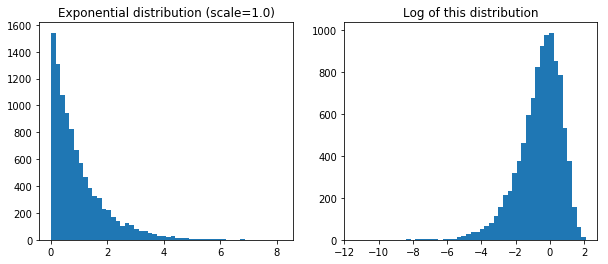

In [26]:
expon_distrib = expon(scale=1.)
samples = expon_distrib.rvs(10000, random_state=42)
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.title("Exponential distribution (scale=1.0)")
plt.hist(samples, bins=50)
plt.subplot(122)
plt.title("Log of this distribution")
plt.hist(np.log(samples), bins=50)
plt.show()

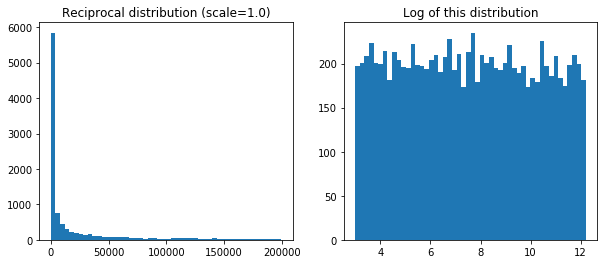

In [27]:
reciprocal_distrib = reciprocal(20, 200000)
samples = reciprocal_distrib.rvs(10000, random_state=42)
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.title("Reciprocal distribution (scale=1.0)")
plt.hist(samples, bins=50)
plt.subplot(122)
plt.title("Log of this distribution")
plt.hist(np.log(samples), bins=50)
plt.show()

# 3. 添加一个转换器，选出最重要的特征

In [29]:
from  sklearn.base import BaseEstimator, TransformerMixin

def indices_of_top_k(arr, k):
    return np.sort(no.argpartition(np.array(arr), -k)[-k:])

class TopFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(selef, feature_importances, k):
        self.feature_importances = feature_importances
        selt.k = k
    def fit(self, X, y=None):
        self.feature_indices_ = indices_of_top_k(self.feature_importances)
        return self
    def transform(self, X):
        return X[:, self.feature_indices_]

# 4  尝试创建一个完整的数据准备和最终预测的管道。

In [32]:
prepare_select_and_predict_pipeline = Pipeline([
    ('preparation', full_pipeline),
#     ('feature_selection', TopFeatureSelector(feature_importances, k)),
    ('svm_reg', SVR(**rnd_search.best_params_))
])